In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir -p /root/.ssh/
!cp /content/drive/Shareddrives/CSCI\ 567:\ ML/deploy_keys/id_ed25519* /root/.ssh
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
# github.com:22 SSH-2.0-babeld-756a9a22
Hi rogue-agents-sc/rogue-gym! You've successfully authenticated, but GitHub does not provide shell access.


In [7]:
!pip install /content/drive/Shareddrives/CSCI\ 567:\ ML/rogue-gym/rogue_gym-0.0.2-cp310-cp310-linux_x86_64.whl

Processing ./drive/Shareddrives/CSCI 567: ML/rogue-gym/rogue_gym-0.0.2-cp310-cp310-linux_x86_64.whl


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from rogue_gym.envs import RogueEnv

def is_player_near_gold(matrix, player_symbol = '@', gold_symbol = '*'):
    dungeon_boundaries = []
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == '-' or element == '|':
                dungeon_boundaries.append((i, j))

    player_found = False
    gold_found = False
    for i, row in enumerate(matrix):
        for j, element in enumerate(row):
            if element == player_symbol:
                player_found = True
            elif element == gold_symbol:
                gold_found = True

            if player_found and gold_found:
                break

    return player_found and gold_found

def process_strings_to_matrix(string_list):
    max_length = max(len(s) for s in string_list)
    matrix = [[' ' for _ in range(max_length)] for _ in range(len(string_list))]

    for i, s in enumerate(string_list):
        for j, char in enumerate(s):
            matrix[i][j] = char

    return matrix

#symbols within rogue gym
symbols = [" ","@","#",".","-","%","+","^","!","?","]",")","/","*",":","=",",","|"]

symbol_to_index = {symbol: i for i, symbol in enumerate(symbols)}

#one hot encode the symbols
def symbols_to_one_hot(symbols, symbol_to_index):
    num_symbols = len(symbol_to_index)
    one_hot_matrix = np.zeros((len(symbols), num_symbols), dtype=int)
    for i, row in enumerate(symbols):
        for symbol in row:
            one_hot_matrix[i, symbol_to_index[symbol]] = 1
    return one_hot_matrix

#Configuration for the Rogue-Gym environment
CONFIG = {
    "width": 32,
    "height": 16,
    "seed_range": [0, 40],
    "hide_dungeon": True,
    "dungeon": {
        "style": "rogue",
        "room_num_x": 2,
        "room_num_y": 2,
    },
    "enemies": {
        "enemies": [],
    },
}

env = RogueEnv(max_steps=100, config_dict=CONFIG)
rewards = 0

class HighLevelPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HighLevelPolicy, self).__init__()
        self.lstm = nn.LSTM(input_dim + output_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, prev_action_probs):
        #combine the state with the previous action probabilities
        x = torch.cat([x, prev_action_probs.unsqueeze(1).expand(-1, x.size(1), -1)], dim=-1)

        lstm_out, _ = self.lstm(x)
        action_probs = F.softmax(self.fc(lstm_out[:, -1, :]), dim=-1)
        return action_probs

class LowLevelPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LowLevelPolicy, self).__init__()
        self.lstm = nn.LSTM(input_dim + output_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, prev_action_probs):
        #combine the state with the previous action probabilities
        x = torch.cat([x, prev_action_probs.unsqueeze(1).expand(-1, x.size(1), -1)], dim=-1)

        lstm_out, _ = self.lstm(x)
        action_probs = F.softmax(self.fc(lstm_out[:, -1, :]), dim=-1)
        return action_probs


high_policy = HighLevelPolicy(input_dim=24, hidden_dim=128, output_dim=len(env.ACTIONS))
low_policy = LowLevelPolicy(input_dim=24, hidden_dim=128, output_dim=len(env.ACTIONS))

high_opt = optim.Adam(high_policy.parameters(), lr=.2)
low_opt = optim.Adam(low_policy.parameters(), lr=.2)

rewards_over_time = []

#training loop, can edit the number of episodes
for episode in range(1000):
    env = RogueEnv(max_steps=100, config_dict=CONFIG)
    state = env.reset()
    total_reward = 0
    prev_high_action_probs = torch.zeros(1, len(env.ACTIONS))
    prev_low_action_probs = torch.zeros(1, len(env.ACTIONS))
    need_to_update = False
    result_matrix = process_strings_to_matrix(state.dungeon)
    one_hot_matrix = symbols_to_one_hot(result_matrix,symbol_to_index)

    while not state.is_terminal:

        already_ran = False

        #high-level policy
        high_action_probs = high_policy(torch.from_numpy(one_hot_matrix).float().unsqueeze(0), prev_high_action_probs)

        #get action from the probabilites from high-level policy
        high_action = torch.multinomial(high_action_probs, 1).item()


        #check if gold is near, if not then use high action
        if is_player_near_gold(result_matrix):
            if need_to_update == False:
              need_to_update = True


            #update high-level action probabilities
            prev_high_action_probs = high_action_probs.detach().clone()

            #low-level policy
            low_action_probs = low_policy(torch.from_numpy(one_hot_matrix).float().unsqueeze(0), prev_low_action_probs)

            #get action from the probabilites from low-level policy
            try:
              low_action = torch.multinomial(low_action_probs, 1).item()
            except RuntimeError:
              already_ran = True
              low_action = 0

            #if low policy is 0, meaning '.' which is no operation, ignore it and go to high action
            if low_action == 0:
              next_state, reward, done, info = env.step(env.ACTIONS[high_action])
              total_reward += reward
            else:
              next_state, reward, done, info = env.step(env.ACTIONS[low_action])
              total_reward += reward

            #update low-level action probabilities
            prev_low_action_probs = low_action_probs.detach().clone()

        else:
          #if gold was checked and high level policy wasn't executed, then continue
          if already_ran:
            continue
          #no gold present then do high action
          else:
            next_state, reward, done, info = env.step(env.ACTIONS[high_action])
            total_reward += reward

        state = next_state
        result_matrix = process_strings_to_matrix(state.dungeon)
        one_hot_matrix = symbols_to_one_hot(result_matrix,symbol_to_index)

    rewards_over_time.append(total_reward)

    #update the high-level policy
    high_advantage = total_reward
    high_loss = -torch.log(high_action_probs[0, high_action]) * high_advantage
    high_opt.zero_grad()
    high_loss.backward()
    high_opt.step()

    #update the low-level policy
    if need_to_update:
      low_advantage = total_reward
      low_loss = -torch.log(low_action_probs[0, low_action]) * low_advantage
      low_opt.zero_grad()
      low_loss.backward()
      low_opt.step()
      need_to_update = False


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


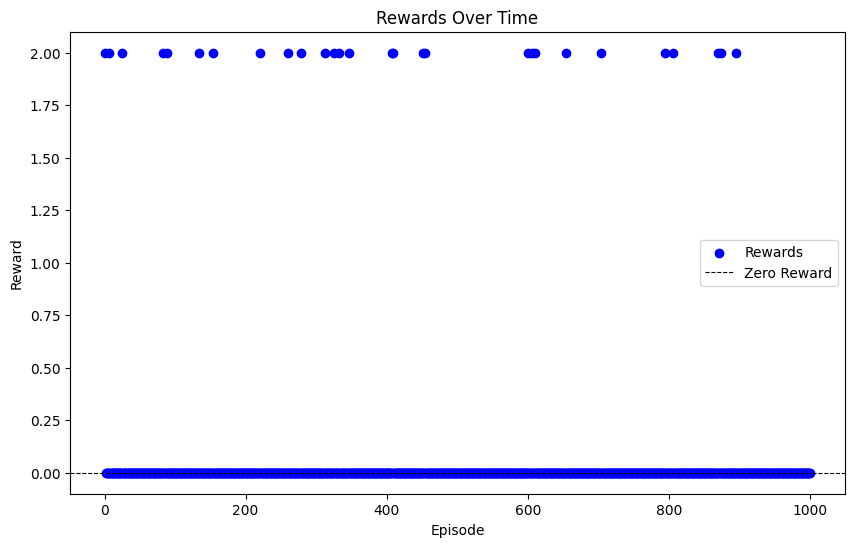

In [21]:
import matplotlib.pyplot as plt

episodes = list(range(1, len(rewards_over_time) + 1))

plt.figure(figsize=(10, 6))
plt.scatter(episodes, rewards_over_time, marker='o', color='b', label='Rewards')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Reward')

plt.title('Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.legend()
plt.show()
